In [1]:
import pandas as pd
import torch
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torchvision import ops
import matplotlib.pyplot as plt

c:\users\olexandr\.virtualenvs\dataspellenv\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


In [4]:
map_assignment_ground_truth = pd.read_csv('./map_assignment_ground_truth.csv', delimiter=',', low_memory=False)
map_assignment_predictions = pd.read_csv('./map_assignment_predictions.csv', delimiter=',', low_memory=False)

In [6]:
classes = map_assignment_ground_truth['class'].unique()
images = map_assignment_ground_truth['filename'].unique()

In [7]:
map_assignment_predictions.head()

,filename,class,score,xmin,ymin,xmax,ymax,index_pred
0,XXX_TUS233_1593434074.9331036_1.jpg,Vehicle,0.999835,561.244375,84.548545,592.644663,109.890481,0
1,XXX_TUS233_1593434074.9331036_1.jpg,Vehicle,0.999824,545.757011,117.405949,592.049385,156.095089,1
2,XXX_TUS233_1593434074.9331036_1.jpg,Vehicle,0.987250,546.726793,53.183871,567.340834,69.941495,2
3,XXX_TUS233_1593434074.9331036_1.jpg,Vehicle,0.982133,568.682404,36.318524,581.257904,45.800853,3
4,XXX_TUS233_1593434074.9331036_1.jpg,Vehicle,0.921274,588.586596,34.530102,599.382398,43.370380,4


In [8]:
def pytorch_map(predictions, ground_truth):
    predictions = predictions.copy(deep=True)
    ground_truth = ground_truth.copy(deep=True)
    classes_dict = {
        'Vehicle': 0,
        'Human': 1,
        'Object': 2
    }
    ground_truth['class_num'] = ground_truth[['class']].replace(classes_dict)
    predictions['class_num'] = predictions[['class']].replace(classes_dict)

    predictions_lst = []
    ground_truths_lst = []

    for image_name in images:
        filtered_predictions = predictions[map_assignment_predictions['filename'] == image_name]
        filtered_ground_truths = ground_truth[map_assignment_ground_truth['filename'] == image_name]

        predictions_lst.append({
            'boxes': torch.tensor(filtered_predictions[['xmin', 'ymin', 'xmax', 'ymax']].to_numpy()),
            'scores': torch.tensor(filtered_predictions['score'].to_numpy()),
            'labels': torch.tensor(filtered_predictions['class_num'].to_numpy())
        })

        ground_truths_lst.append({
            'boxes': torch.tensor(filtered_ground_truths[['xmin', 'ymin', 'xmax', 'ymax']].to_numpy()),
            'labels': torch.tensor(filtered_ground_truths['class_num'].to_numpy())
        })
    metric = MeanAveragePrecision(class_metrics=True)
    metric.update(predictions_lst, ground_truths_lst)
    res = metric.compute()
    return res

pytorch_map(map_assignment_predictions, map_assignment_ground_truth)

{'map': tensor(0.5020),
 'map_50': tensor(0.8738),
 'map_75': tensor(0.5159),
 'map_small': tensor(0.3968),
 'map_medium': tensor(0.5234),
 'map_large': tensor(0.6420),
 'mar_1': tensor(0.3768),
 'mar_10': tensor(0.5548),
 'mar_100': tensor(0.5691),
 'mar_small': tensor(0.4932),
 'mar_medium': tensor(0.6080),
 'mar_large': tensor(0.6832),
 'map_per_class': tensor([0.5957, 0.4632, 0.4471]),
 'mar_100_per_class': tensor([0.6454, 0.5541, 0.5079])}

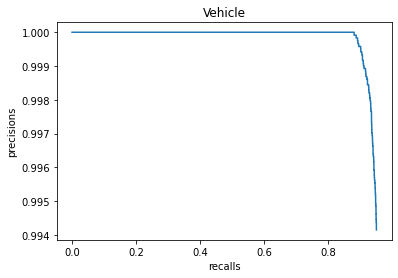

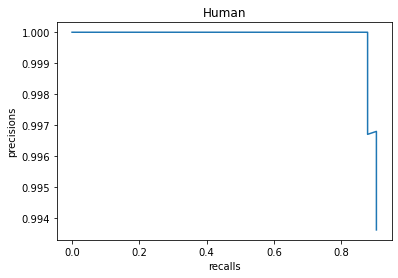

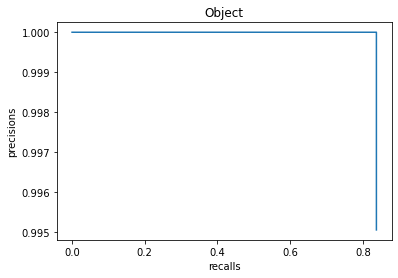

mAP for iou 50 tensor(0.8970)


In [9]:
class MAP:
    def __init__(self, ground_truth_data, prediction_data, iou_thresh):
        self.ground_truth_data: pd.DataFrame = ground_truth_data.copy(deep=True)
        self.prediction_data: pd.DataFrame = prediction_data.copy(deep=True)

        self.classes = map_assignment_ground_truth['class'].unique()
        self.num_classes = len(self.classes)
        self.classes_dict = {cls:i for i, cls in enumerate(classes)}
        self.ground_truth_data['class_num'] = self.ground_truth_data[['class']].replace(self.classes_dict)
        self.prediction_data['class_num'] = self.prediction_data[['class']].replace(self.classes_dict)

        self.filenames = map_assignment_ground_truth['filename'].unique()
        #self.ground_truth_by_image =

        self.iou_thresh = iou_thresh

    def calculate_map(self):
        average_precisions = []
        for cls_name, i in self.classes_dict.items():
            precisions, recalls = self.calculate_average_precision(i)
            plt.plot(recalls, precisions)
            plt.xlabel('recalls')
            plt.ylabel('precisions')
            plt.title(cls_name)
            plt.show()
            average_precisions.append(torch.trapz(precisions, recalls))
        return sum(average_precisions) / len(average_precisions)

    def calculate_average_precision(self, cls_i):
        epsilon = 1e-6
        detections = self.prediction_data[self.prediction_data['class_num'] == cls_i]
        ground_truth = self.ground_truth_data[self.ground_truth_data['class_num'] == cls_i]

        amount_bboxes = dict(map_assignment_ground_truth.groupby('filename')['filename'].count())
        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        detections = detections.sort_values(by=['score'], ascending=False)

        TP = torch.zeros(len(detections))
        FP = torch.zeros(len(detections))
        total_true_boxes = len(ground_truth)

        for detection_idx, detection in enumerate(detections.itertuples()):
            ground_truth_bboxes_for_image = ground_truth[ground_truth['filename'] == detection.filename]
            best_iou = 0
            best_gt_idx = None
            for idx, gt in enumerate(ground_truth_bboxes_for_image.itertuples()):
                iou = self.intersection_over_union(
                    torch.tensor([[detection.xmin, detection.ymin, detection.xmax, detection.ymax]]),
                    torch.tensor([[gt.xmin, gt.ymin, gt.xmax, gt.ymax]]),
                )
                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_gt_idx is not None and best_iou > self.iou_thresh:
                if amount_bboxes[detection.filename][best_gt_idx] == 0:
                    TP[detection_idx] = 1
                    amount_bboxes[detection.filename][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1

        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_boxes + epsilon)
        precisions = TP_cumsum / (TP_cumsum + FP_cumsum + epsilon)
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        return precisions, recalls

    def intersection_over_union(self, fst_bbox, scnd_bbox):
        iou = ops.box_iou(fst_bbox, scnd_bbox)
        return iou.numpy()[0][0]


test = MAP(
    ground_truth_data=map_assignment_ground_truth,
    prediction_data=map_assignment_predictions,
    iou_thresh=0.5,
)
map_50 = test.calculate_map()
print('mAP for iou 50', map_50)